## Imports

In [23]:
# Import Python packages
import os


# Import installed libraries
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import tensorflow as tf
print('Tensorflow version', tf.version.VERSION)



Tensorflow version 2.12.1


## Constants

In [15]:
# Constants
EPOCHS = 100
IMG_HEIGHT = 150
IMG_WIDHT = 150
BATCH_SIZE = 32
INPUT_SHAPE = (150, 150, 3)

# File paths
DATASET = '/Users/abhidgd/Desktop/mcmaster/cps-dl/fire-detection/data/'
FIRE_IMG_PATH = DATASET + '/1'
NO_FIRE_IMG_PATH = DATASET + '/0'
FIRE_IMG = FIRE_IMG_PATH + '/1.jpg'
RAND_IMG = NO_FIRE_IMG_PATH + '/1.jpg'
CHECKPOINT_FILEPATH = './fire-detection/temp/checkpoint'


print('Constants defined')


Constants defined


## Functions

In [4]:
def count_files_in_folders(parent_folder) -> dict:
    """Count files in given folder. Return dictionary with folder and count."""
    folder_names = os.listdir(parent_folder)
    file_count = {}

    for folder_name in folder_names:
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            file_count[folder_name] = len(
                [file for file in os.listdir(folder_path) if os.path.isfile(
                    os.path.join(folder_path, file)
                    )
                ]
            )
        else:
            file_count[folder_name] = 0

    return file_count


def load_and_prep_image(filename, img_shape = 300):
    """Funtion to read image and transform image to tensor."""
    img = tf.io.read_file(filename) #read image
    img = tf.image.decode_image(img) # decode the image to a tensor
    img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
    return img


def pred_and_plot(model, filename, class_names):
    """Funtion to read image and give desired output with image.

    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    if len(pred[0]) > 1: # check for multi-class
        # if more than one output, take the max
        pred_class = class_names[pred.argmax()]
    else:
        # if only one output, round
        pred_class = class_names[int(tf.round(pred)[0][0])]

    # Plot the image and predicted class
    sh_image = plt.imread(filename)
    plt.imshow(sh_image)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

    # specifying path to sample image from list of test images.




## Get data

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET,
        validation_split = 0.2,
        image_size=(IMG_HEIGHT, IMG_WIDHT),
        batch_size=BATCH_SIZE,
        subset="training",
        seed=50,
)
test_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET,
        validation_split=0.2,
        image_size=(IMG_HEIGHT, IMG_WIDHT),
        batch_size=BATCH_SIZE,
        subset="validation",
        seed=50,
)

# Verify data
print("BatchDataset type objects returned.")
print("Class names:", train_ds.class_names)

Found 651 files belonging to 2 classes.


Using 521 files for training.
Found 651 files belonging to 2 classes.
Using 130 files for validation.
BatchDataset type objects returned.
Class names: ['0', '1']


## View image data

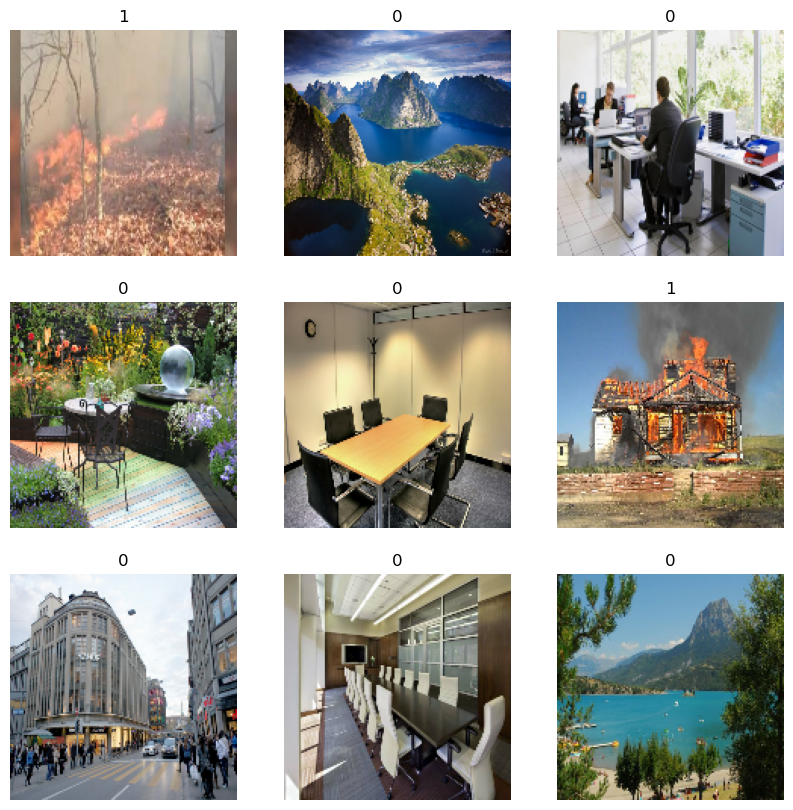

In [41]:
i = 1
for (image, label) in train_ds.take(1):
    # Plot the first 9 images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[label[i]])
        plt.axis("Off")
    plt.show()